In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error

import scipy.stats as st

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

#### retrieve data

In [2]:
data = pd.read_csv('sales.csv', index_col=0)
data.columns = data.columns.str.lower()
data

,store_id,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
425390,366,4,2013-04-18,517,1,0,0,0,4422
291687,394,6,2015-04-11,694,1,0,0,0,8297
411278,807,4,2013-08-29,970,1,1,0,0,9729
664714,802,2,2013-05-28,473,1,1,0,0,6513
540835,726,4,2013-10-10,1068,1,1,0,0,10882
...,...,...,...,...,...,...,...,...,...
359783,409,6,2013-10-26,483,1,0,0,0,4553
152315,97,1,2014-04-14,987,1,1,0,0,12307
117952,987,1,2014-07-07,925,1,0,0,0,6800
435829,1084,4,2014-06-12,725,1,0,0,0,5344


In [3]:
data.isna().sum().sum()

0

#### sanity checks to make sure the data is correct + EDA

In [4]:
drop_list = []

In [5]:
display(data.shape)
data.drop_duplicates()
display(data.shape)

(640840, 9)

(640840, 9)

In [6]:
#should be one through 7
display(data['day_of_week'].value_counts())

day_of_week
5    92138
4    91972
2    91686
3    91651
6    91347
7    91075
1    90971
Name: count, dtype: int64

In [7]:
display(data['open'].value_counts())

open
1    532016
0    108824
Name: count, dtype: int64

In [8]:
# make sure there's no sales when store is closed
data.groupby('open')['sales'].sum()

open
0             0
1    3702433241
Name: sales, dtype: int64

In [9]:
display(print(data['promotion'].value_counts(normalize=True) * 100))

promotion
0    61.828225
1    38.171775
Name: proportion, dtype: float64


None

In [10]:
print(data['state_holiday'].value_counts(normalize=True) * 100)

state_holiday
0    96.929031
a     2.003932
b     0.657574
c     0.409463
Name: proportion, dtype: float64


In [11]:
multiple_holidays_count = 0
holiday_by_store = data.groupby('store_id')['state_holiday'].unique()
# Check if any store_ID has more than one type of state holiday ('a', 'b', 'c')
for store_id, holidays in holiday_by_store.items():
    if len(set(holidays) - {'0'}) > 1: 
        multiple_holidays_count += 1

print(f"Number of store_iss with multiple state holidays: {multiple_holidays_count}")
# --> turn into 0 or 1, a,b,c 

Number of store_iss with multiple state holidays: 1115


In [12]:
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x == 7 else 0)
drop_list.append('day_of_week')

In [13]:
data['state_holiday'] = data['state_holiday'].map({'0': 0,'a': 1, 'b': 1, 'c': 1})
display(data['state_holiday'].value_counts())

state_holiday
0    621160
1     19680
Name: count, dtype: int64

In [14]:
# check for invalid sales
data[
    (data['nb_customers_on_day'] == 0) &
    (data['sales'] != 0) &
    ((data['open'] != 0) | (data['promotion'] != 0) | (data['state_holiday'] != 0) | (data['school_holiday'] != 0))
]

,store_id,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,is_weekend


In [15]:
display(data['school_holiday'].value_counts())

school_holiday
0    526468
1    114372
Name: count, dtype: int64

In [16]:
display(data.groupby('day_of_week')['sales'].mean())
display(data.groupby('day_of_week')['sales'].sum())

day_of_week
1    7812.766948
2    7004.780054
3    6555.350536
4    6255.380268
5    6726.462697
6    5850.032820
7     210.680439
Name: sales, dtype: float64

day_of_week
1    710735222
2    642240264
3    600804432
4    575319834
5    619762820
6    534382948
7     19187721
Name: sales, dtype: int64

> so the stores are not always closed on sundays, but smaller purchases 

### feature engineering

In [17]:
# retrieve data from date field
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [18]:
display(data['year'].value_counts())

year
2013    256337
2014    235602
2015    148901
Name: count, dtype: int64

In [19]:
display(data['month'].value_counts())

month
5     65529
3     65399
1     65325
6     63370
4     63030
7     61714
2     58989
12    40066
10    40037
8     39910
11    38771
9     38700
Name: count, dtype: int64

In [20]:
drop_list.append('date')

#### visualize 

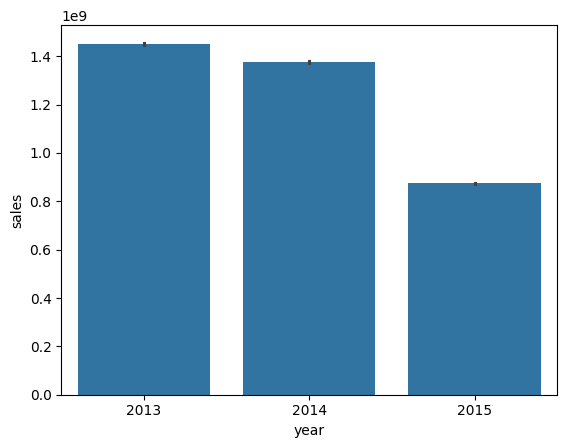

In [21]:
sns.barplot(data=data, x='year', y='sales', estimator='sum')
plt.show()

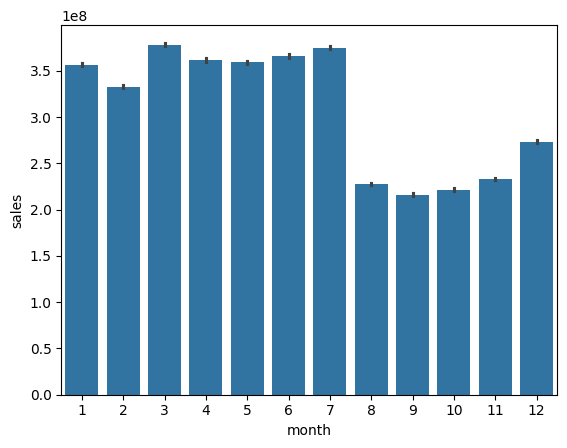

In [22]:
sns.barplot(data=data, x='month', y='sales', estimator='sum')
plt.show()

In [23]:
data['part_of_year'] = data['month'].apply(lambda x: 'first' if x <= 7 else 'last')
drop_list.append('month')

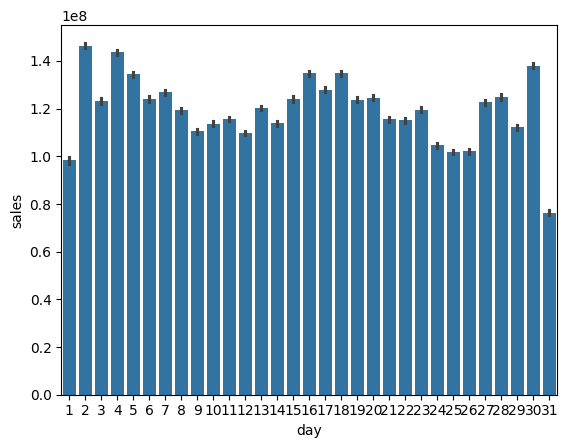

In [24]:
sns.barplot(data=data, x='day', y='sales', estimator='sum')
plt.show()

In [25]:
# looks like payday is twice a month
range1 = (2, 9)
range2 = (15, 24)  
data['payday'] = np.where(
    (data['day'].between(*range1)) | (data['day'].between(*range2)), 1, 0)
drop_list.append('day')
data

,store_id,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,is_weekend,year,month,day,part_of_year,payday
425390,366,4,2013-04-18,517,1,0,0,0,4422,0,2013,4,18,first,1
291687,394,6,2015-04-11,694,1,0,0,0,8297,0,2015,4,11,first,0
411278,807,4,2013-08-29,970,1,1,0,0,9729,0,2013,8,29,last,0
664714,802,2,2013-05-28,473,1,1,0,0,6513,0,2013,5,28,first,0
540835,726,4,2013-10-10,1068,1,1,0,0,10882,0,2013,10,10,last,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,409,6,2013-10-26,483,1,0,0,0,4553,0,2013,10,26,last,0
152315,97,1,2014-04-14,987,1,1,0,0,12307,0,2014,4,14,first,0
117952,987,1,2014-07-07,925,1,0,0,0,6800,0,2014,7,7,first,1
435829,1084,4,2014-06-12,725,1,0,0,0,5344,0,2014,6,12,first,0


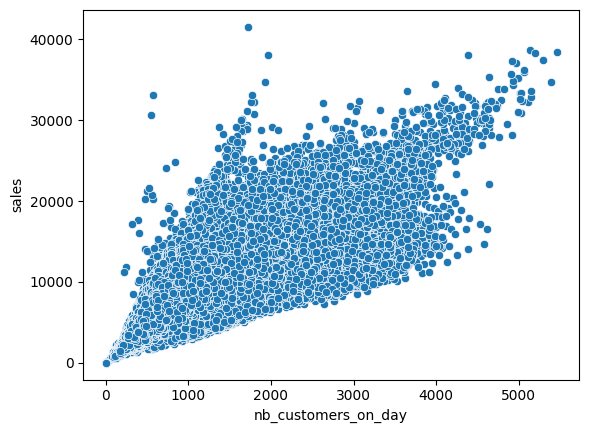

In [26]:
sns.scatterplot(data=data, x='nb_customers_on_day', y='sales')
plt.show()

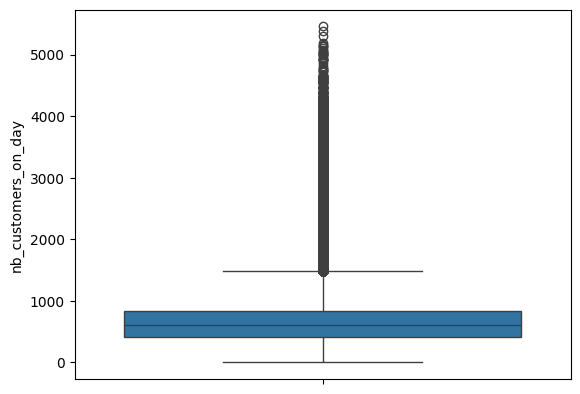

In [27]:
# check outliers
# plt.figure(figsize=(5, 20))
sns.boxplot(data=data, y='nb_customers_on_day')
plt.show()

In [28]:
# remove outliers
data = data[data['nb_customers_on_day'] <= 3000]

#### extended feature selection

In [29]:
data.dtypes

store_id                        int64
day_of_week                     int64
date                   datetime64[ns]
nb_customers_on_day             int64
open                            int64
promotion                       int64
state_holiday                   int64
school_holiday                  int64
sales                           int64
is_weekend                      int64
year                            int32
month                           int32
day                             int32
part_of_year                   object
payday                          int64
dtype: object

In [30]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
store_id,638239.0,557.781912,1.0,280.0,557.0,837.0,1115.0,322.028264
day_of_week,638239.0,4.001346,1.0,2.0,4.0,6.0,7.0,1.996586
date,638239,2014-04-11 00:16:14.817270528,2013-01-01 00:00:00,2013-08-16 00:00:00,2014-04-02 00:00:00,2014-12-12 00:00:00,2015-07-31 00:00:00,NaN
nb_customers_on_day,638239.0,622.005045,0.0,404.0,609.0,834.0,3000.0,428.634711
open,638239.0,0.829493,0.0,1.0,1.0,1.0,1.0,0.376078
promotion,638239.0,0.381279,0.0,0.0,0.0,1.0,1.0,0.485701
state_holiday,638239.0,0.030744,0.0,0.0,0.0,0.0,1.0,0.172623
school_holiday,638239.0,0.178389,0.0,0.0,0.0,0.0,1.0,0.38284
sales,638239.0,5722.819608,0.0,3720.0,5732.0,7828.0,41551.0,3747.830329
is_weekend,638239.0,0.142318,0.0,0.0,0.0,0.0,1.0,0.349376


In [31]:
selected_columns = ['open', 'promotion', 'state_holiday', 'school_holiday', 'sales', 'store_id', 'is_weekend', 'payday']
selected_data = data[selected_columns]

correlation_matrix = selected_data.corr()
sales_correlation = correlation_matrix['sales']

print("Correlation coefficients with sales:")
print(sales_correlation)


Correlation coefficients with sales:
open              0.692301
promotion         0.462044
state_holiday    -0.262605
school_holiday    0.086329
sales             1.000000
store_id          0.000760
is_weekend       -0.605209
payday            0.050075
Name: sales, dtype: float64


In [32]:
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x == 7 else 0)
drop_list.append('day_of_week')
drop_list.append('year')

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_30101/2759342779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x == 7 else 0)


In [33]:
drop_list.append('year')
data.drop(columns=drop_list, inplace=True)

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_30101/3622297098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=drop_list, inplace=True)


#### Hypothesis Testing

> days of the week <> sales 
> H0 for ANOVA is always that the means of the various groups are the same
> H1 is that they are not the same

In [34]:
open_groups = []
for status in [0,1]:
    day_sales = data[data['state_holiday'] == status]['sales'] 
    open_groups.append(day_sales)
    
print(len(open_groups))
f_stat, p_val = st.f_oneway(*open_groups)
print(f_stat)
print(p_val)

2
47273.81020027174
0.0


In [35]:
open_groups = []
for status in [0,1]:
    day_sales = data[data['school_holiday'] == status]['sales'] 
    open_groups.append(day_sales)
    
print(len(open_groups))
f_stat, p_val = st.f_oneway(*open_groups)
print(f_stat)
print(p_val)

2
4792.2601068574695
0.0


#### setup model

In [36]:
X = data.drop(columns=['sales'])
y = data['sales']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [38]:
# check data
X_train

,store_id,nb_customers_on_day,open,promotion,state_holiday,school_holiday,is_weekend,part_of_year,payday
710086,451,483,1,1,0,0,0,first,1
362964,1088,658,1,1,0,1,0,first,1
511909,384,869,1,0,0,1,0,first,0
459687,435,0,0,0,0,0,1,first,0
638090,401,0,0,0,0,0,1,last,0
...,...,...,...,...,...,...,...,...,...
319548,1034,251,1,0,0,0,0,first,0
570738,8,410,1,0,0,0,0,first,0
16136,197,947,1,1,0,0,0,last,0
431528,196,0,0,0,0,0,1,first,0


In [39]:
categorical_to_encode = ['part_of_year', 'open', 'promotion','state_holiday', 'school_holiday', 'is_weekend', 'payday'] 
numerical_to_scale = ['nb_customers_on_day']

In [40]:
## scale numericals
scaler = MinMaxScaler()
X_train[numerical_to_scale] = scaler.fit_transform(X_train[numerical_to_scale])
X_test[numerical_to_scale] = scaler.transform(X_test[numerical_to_scale])

In [41]:
## ordinal encode categorical
encoder = OrdinalEncoder()
X_train[categorical_to_encode] = encoder.fit_transform(X_train[categorical_to_encode])
X_test[categorical_to_encode] = encoder.transform(X_test[categorical_to_encode])

In [42]:
X_train

,store_id,nb_customers_on_day,open,promotion,state_holiday,school_holiday,is_weekend,part_of_year,payday
710086,451,0.161000,1.0,1.0,0.0,0.0,0.0,0.0,1.0
362964,1088,0.219333,1.0,1.0,0.0,1.0,0.0,0.0,1.0
511909,384,0.289667,1.0,0.0,0.0,1.0,0.0,0.0,0.0
459687,435,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
638090,401,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
319548,1034,0.083667,1.0,0.0,0.0,0.0,0.0,0.0,0.0
570738,8,0.136667,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16136,197,0.315667,1.0,1.0,0.0,0.0,0.0,1.0,0.0
431528,196,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0


> build models

In [43]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_preds = linear_model.predict(X_test)
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_preds))
r2 = r2_score(y_test,linear_preds)
display(r2)
display(linear_rmse)

0.8559484315273544

1422.770848991585

In [44]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, tree_preds))
tree_r2 = r2_score(y_test, tree_preds)

display(tree_r2)
display(tree_rmse)

0.9470454061203792

862.6364074857393

In [45]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)
print("Random Forest R2 Score:", rf_r2)
print("Random Forest RMSE:", rf_rmse)

Random Forest R2 Score: 0.969136593988469
Random Forest RMSE: 658.5638516408336


Random Forest R2 Score: 0.9692687952256781  
Random Forest RMSE: 657.1518819417315

In [46]:
X_train

,store_id,nb_customers_on_day,open,promotion,state_holiday,school_holiday,is_weekend,part_of_year,payday
710086,451,0.161000,1.0,1.0,0.0,0.0,0.0,0.0,1.0
362964,1088,0.219333,1.0,1.0,0.0,1.0,0.0,0.0,1.0
511909,384,0.289667,1.0,0.0,0.0,1.0,0.0,0.0,0.0
459687,435,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
638090,401,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
319548,1034,0.083667,1.0,0.0,0.0,0.0,0.0,0.0,0.0
570738,8,0.136667,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16136,197,0.315667,1.0,1.0,0.0,0.0,0.0,1.0,0.0
431528,196,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### build model on full data set

In [47]:
X = data.drop(columns=['sales'])
y = data['sales']
categorical_to_encode = ['part_of_year', 'open', 'promotion','state_holiday', 'school_holiday', 'is_weekend', 'payday'] 
numerical_to_scale = ['nb_customers_on_day']

In [48]:
## scale numericals
scaler = MinMaxScaler()
X[numerical_to_scale] = scaler.fit_transform(X[numerical_to_scale])
# ordinal encode categorical
encoder = OrdinalEncoder()
X[categorical_to_encode] = encoder.fit_transform(X[categorical_to_encode])

In [49]:
X

,store_id,nb_customers_on_day,open,promotion,state_holiday,school_holiday,is_weekend,part_of_year,payday
425390,366,0.172333,1.0,0.0,0.0,0.0,0.0,0.0,1.0
291687,394,0.231333,1.0,0.0,0.0,0.0,0.0,0.0,0.0
411278,807,0.323333,1.0,1.0,0.0,0.0,0.0,1.0,0.0
664714,802,0.157667,1.0,1.0,0.0,0.0,0.0,0.0,0.0
540835,726,0.356000,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
359783,409,0.161000,1.0,0.0,0.0,0.0,0.0,1.0,0.0
152315,97,0.329000,1.0,1.0,0.0,0.0,0.0,0.0,0.0
117952,987,0.308333,1.0,0.0,0.0,0.0,0.0,0.0,1.0
435829,1084,0.241667,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Initialize Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the model on the training data
rf_model.fit(X, y)

RandomForestRegressor()

In [51]:
# added to gitignore
import pickle
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

with open('random_forest_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open('random_forest_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

### apply on full set

In [73]:
# Load the trained RandomForestRegressor model
with open('random_forest_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Load the scaler
with open('random_forest_scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Load the encoder
with open('random_forest_encoder.pkl', 'rb') as file:
    encoder = pickle.load(file)

In [107]:
# Function that returns and saves df of sales predictions
def get_sales_predictions(model, scaler, encoder, test_data_url):
    test_data = pd.read_csv(test_data_url, index_col=None)

    # rename, lower
    test_data.columns = test_data.columns.str.lower()
    test_data = test_data.rename(columns={'true_index': 'index'})

    # feature enigneering
    test_data['state_holiday'] = test_data['state_holiday'].map({'0': 0,'a': 1, 'b': 1, 'c': 1})
    test_data['date'] = pd.to_datetime(test_data['date'])
    test_data['year'] = test_data['date'].dt.year
    test_data['month'] = test_data['date'].dt.month
    test_data['day'] = test_data['date'].dt.day
    test_data['part_of_year'] = test_data['month'].apply(lambda x: 'first' if x <= 7 else 'last')
    test_data['is_weekend'] = test_data['day_of_week'].apply(lambda x: 1 if x == 7 else 0)
    range1 = (2, 9)
    range2 = (15, 24)  
    test_data['payday'] = np.where((test_data['day'].between(*range1)) | (test_data['day'].between(*range2)), 1, 0)

    #encode and scale 
    categorical_to_encode = ['part_of_year', 'open', 'promotion','state_holiday', 'school_holiday', 'is_weekend', 'payday'] 
    numerical_to_scale = ['nb_customers_on_day']
    test_data[numerical_to_scale] = scaler.transform(test_data[numerical_to_scale])
    test_data[categorical_to_encode] = encoder.transform(test_data[categorical_to_encode])

    # filter data 
    selected_columns = ['store_id', 'nb_customers_on_day', 'open', 'promotion', 'state_holiday',
        'school_holiday', 'is_weekend', 'part_of_year', 'payday']
    model_data = test_data[selected_columns]

    # get predictions 
    test_data['Sales'] = model.predict(model_data)
    sales_predictions = test_data[['index', 'Sales']]
    sales_predictions.set_index('index', inplace=True)

    # save to file
    sales_predictions.to_csv('sales_predictions.csv')

    # returns df
    return sales_predictions

In [108]:
sales_predictions = get_sales_predictions(model, scaler, encoder, 'validation_for_students.csv')
sales_predictions

,Sales
index,
7,0.000000
19,3615.922333
31,6229.532500
45,3831.610000
56,3761.130000
...,...
712004,5880.156667
712018,10838.720000
712020,17389.204667
